In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()

global_path = os.getenv('global_path')
sys.path.append(global_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from athena import Strategy, Backtest
from athena.data import CryptoDataHandler
import pandas as pd
import matplotlib.pyplot as plt

from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [4]:
data_handler = CryptoDataHandler(start_date='20240101', end_date='20241201')

In [5]:
data_directory = "/Users/zhoupeng/Desktop/crypto_database/data/15MINS"

prices_df = data_handler.create_prices_dataframe(data_directory, fields=['Open', 'Close'])

In [6]:
# 定义动量因子
momentum_window = 10

# 创建添加动量因子的新数据表
factors_df = pd.DataFrame(index=prices_df.index)

# 遍历每个标的，计算动量因子
for symbol in prices_df.columns.levels[0]:
    if "Close" in prices_df[symbol].columns:
        # 提取收盘价列
        close_prices = prices_df[(symbol, "Close")]
        
        # 清洗数据：转换为数值
        close_prices = pd.to_numeric(close_prices, errors="coerce")
        
        # 填补缺失值
        close_prices = close_prices.fillna(method="ffill").fillna(method="bfill")
        
        # 计算动量因子（使用前一天的价格除以 momentum_window+1 天前的价格）
        momentum = close_prices.shift(1) / close_prices.shift(momentum_window + 1) - 1
        
        # 将动量因子存储到新表中
        factors_df[symbol] = momentum

# 为动量添加多层索引
factors_df.columns = pd.MultiIndex.from_product([factors_df.columns, ["momentum"]])

In [9]:
from athena.lib import calculate_benchmark_net_value

start_date='2024-08-01'
end_date='2024-08-10'

# 比特币作为benchmark
benchmark = prices_df['BTCUSDT']
benchmark = calculate_benchmark_net_value(benchmark, start_date=start_date, end_date=end_date)

In [10]:
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        pass

    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()

        day_factors = factors_df.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'momentum') # 从高到低排因子

        long_and_short_amount = 1 # 永远是多5空5

        print('因子排名前的股票:')
        print(sorted_factor_series.iloc[:int(long_and_short_amount)].index.tolist())
        long_stocks = sorted_factor_series.iloc[:int(long_and_short_amount)].index.tolist()

        print('因子排名后的股票:')
        print(sorted_factor_series.iloc[int(-long_and_short_amount):].index.tolist())
        short_stocks = sorted_factor_series.iloc[int(-long_and_short_amount):].index.tolist()

        target_percent = 1 / (int(long_and_short_amount)*2)

        # 平仓
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Open')])

                print("当前cash:", self.broker.cash)
                print("当前assets value:", self.broker.assets_value)
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Open')])

                print("当前cash:", self.broker.cash)
                print("当前assets value:", self.broker.assets_value)
        
        # 这里的cash和assets value都应该被正常更新了

        # 调仓
        for stock in long_stocks:
            print("新开多仓/调仓:", stock)
            self.order_target_percent(stock, target_percent=target_percent, price=record[(stock, "Close")], short=False)

            print("当前cash:", self.broker.cash)
            print("当前assets value:", self.broker.assets_value)
        for stock in short_stocks:
            print("新开空仓/调仓:", stock)
            self.order_target_percent(stock, target_percent=target_percent, price=record[(stock, "Close")], short=True)

            print("当前cash:", self.broker.cash)
            print("当前assets value:", self.broker.assets_value)

        print("----------------------")
    
backtest = Backtest(SortedFactorInvestStrategy, prices_df, commission=0.04/100, cash=100_0000, benchmark=benchmark, start_date=start_date, end_date=end_date)
res = backtest.run()


----------------------
2024-08-01 00:00:00: 
因子排名前的股票:
['ZENUSDT']
因子排名后的股票:
['RIFUSDT']
新开多仓/调仓: ZENUSDT
当前cash: 505000.01
当前assets value: 494802.07
新开空仓/调仓: RIFUSDT
当前cash: 10098.00
当前assets value: 989506.20
----------------------
----------------------
2024-08-01 00:15:00: 
因子排名前的股票:
['HIFIUSDT']
因子排名后的股票:
['MEWUSDT']
关多仓: ZENUSDT
当前cash: 504650.78
当前assets value: 494755.51
关空仓: RIFUSDT
当前cash: 999203.85
当前assets value: 4.57
新开多仓/调仓: HIFIUSDT
当前cash: 504595.70
当前assets value: 494414.96
新开空仓/调仓: MEWUSDT
当前cash: 10085.44
当前assets value: 988727.50
----------------------
----------------------
2024-08-01 00:30:00: 
因子排名前的股票:
['STMXUSDT']
因子排名后的股票:
['TNSRUSDT']
关多仓: HIFIUSDT
当前cash: 504199.89
当前assets value: 494410.75
关空仓: MEWUSDT
当前cash: 998314.70
当前assets value: 98.21
新开多仓/调仓: STMXUSDT
当前cash: 504100.32
当前assets value: 494114.99
新开空仓/调仓: TNSRUSDT
当前cash: 9983.76
当前assets value: 988033.99
----------------------
----------------------
2024-08-01 00:45:00: 
因子排名前的股票:
['STMXUSDT']
因子排名后的股票

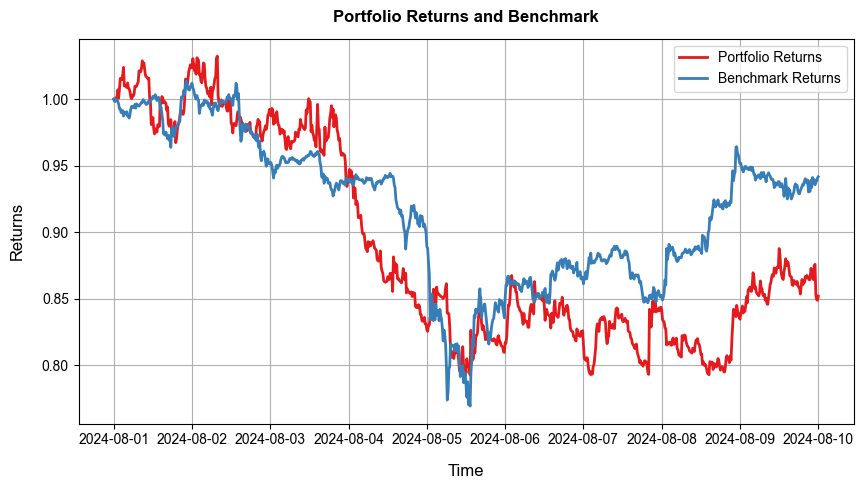

In [11]:
from athena.plotting import Visualization

visualization = Visualization(res)
visualization.plot_portfolio_returns(use_benchmark=True)

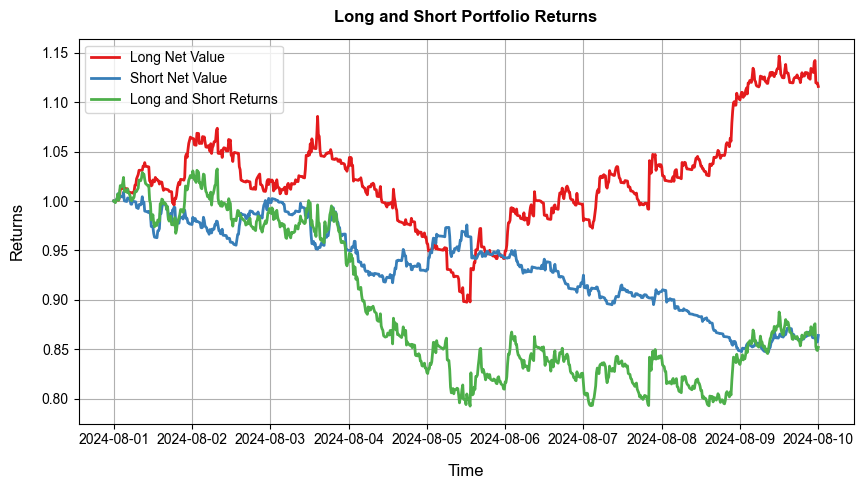

In [12]:
visualization.plot_long_short_portfolio_returns()

In [14]:
import pandas as pd

trades_res = pd.DataFrame(res.trades)

In [15]:
trades_res

,symbol,short,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,ZENUSDT,False,2024-08-01 00:00:00,2024-08-01 00:15:00,9.62900000,9.62800000,51386.65273323,-51.38,-0.0103,197.90027700,999750.71
1,RIFUSDT,True,2024-08-01 00:00:00,2024-08-01 00:15:00,0.10568000,0.10567000,4681151.95254222,46.81,0.0094,197.86293073,999599.65
2,HIFIUSDT,False,2024-08-01 00:15:00,2024-08-01 00:30:00,0.50340000,0.50330000,982142.22455634,-98.21,-0.0198,197.72487264,999303.71
3,MEWUSDT,True,2024-08-01 00:15:00,2024-08-01 00:30:00,0.00659200,0.00659200,74986733.15867826,0.00,0.0000,197.72501799,999105.98
4,STMXUSDT,False,2024-08-01 00:30:00,2024-08-01 00:45:00,0.00869000,0.00871000,5351.32032146,0.10,0.0023,0.01864399,999106.06
...,...,...,...,...,...,...,...,...,...,...,...
1259,COMBOUSDT,False,2024-08-09 22:15:00,2024-08-09 23:30:00,0.44722359,0.43300000,948506.37669543,-13491.16,-3.1804,164.28130444,980576.94
1260,ARBUSDT,True,2024-08-09 23:00:00,2024-08-09 23:30:00,0.56890108,0.57380000,19326.82119205,-94.68,0.0086,4.43589199,980477.82
1261,ARBUSDT,True,2024-08-09 23:00:00,2024-08-09 23:45:00,0.56890108,0.57380000,742369.74868716,-3636.81,-0.8611,170.38870471,976670.62
1262,1000SATSUSDT,False,2024-08-09 23:45:00,2024-08-10 00:00:00,0.00026269,0.00026050,1598585706.33969000,-3500.90,-0.8336,166.57263060,973003.14


In [17]:
trades_res['profit_loss'].sum()

Decimal('107809.32')

In [18]:
trades_res['trade_commission'].sum()

Decimal('128320.01427165')